**Imports**

In [ ]:
#Importing libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
 
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

**Exploratory Data Analysis**

In [ ]:
#Reading our data into a pandas dataframe
sp = pd.read_csv('TSLA.csv')

In [ ]:
sp.head()

In [ ]:
sp.info()

**Checking for missing data**

In [17]:

sp.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [18]:
sp = sp.fillna(method='ffill')

In [19]:
sp.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [20]:
sp=sp[['Date','Adj Close']]

In [21]:
sp.head()

,Date,Adj Close
0,2010-06-29,4.778
1,2010-06-30,4.766
2,2010-07-01,4.392
3,2010-07-02,3.840
4,2010-07-06,3.222


In [22]:
sp.Date = pd.to_datetime(sp.Date)

In [23]:
sp.columns=['ds','y']

In [24]:
train, dev, test = sp[:1800], sp[1800:2250], sp[2250:]

In [25]:
train.head()

,ds,y
0,2010-06-29,4.778
1,2010-06-30,4.766
2,2010-07-01,4.392
3,2010-07-02,3.840
4,2010-07-06,3.222


In [26]:
type(train.ds[0])

pandas._libs.tslibs.timestamps.Timestamp

Let's plot out our data.

Text(0.5, 1.0, ' Index')

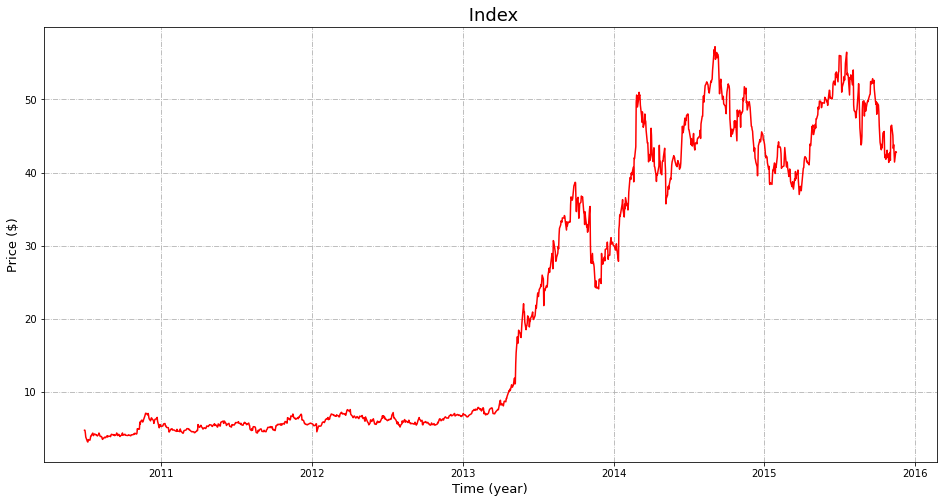

In [27]:
# Setting our layout
plt.figure(figsize=(16,8))
plt.grid(linestyle='-.')

#Plot the data
plt.plot(sp.ds, sp.y, 'r')

# Set title & labels
plt.ylabel('Price ($)', fontsize=13)
plt.xlabel('Time (year)', fontsize=13)
plt.title(' Index', fontsize=18)

**Forecasting using ARIMA**




In [29]:
#Creating a daaframe of log-prices
sp_log = np.log(sp['y'])
log_df = pd.concat([sp['ds'],sp_log],axis=1)
log_df = log_df.set_index('ds')
log_df.head()

,y
ds,
2010-06-29,1.564022
2010-06-30,1.561507
2010-07-01,1.479785
2010-07-02,1.345472
2010-07-06,1.170002


**log- process**

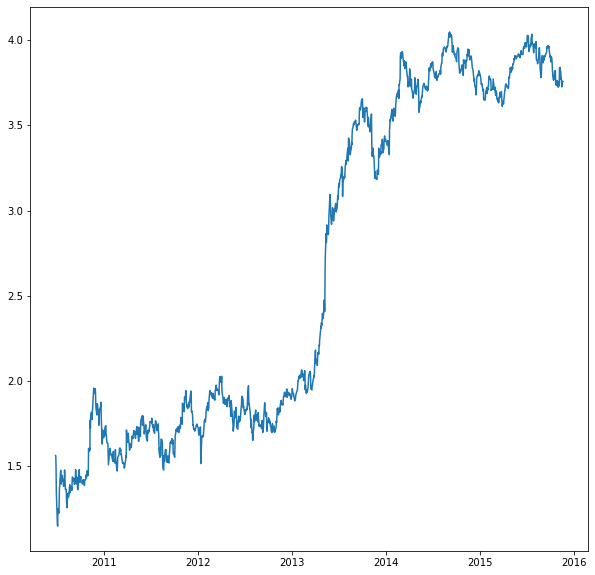

In [30]:
#Plotting the log values
plt.figure(figsize=(10,10))
plt.plot(log_df.index,sp_log)

** Testing for Stationarity**



ADF Statistic: -27.165842459859846
p-value: 0.0
Critical Values:
	1%: -3.4351852261663867
	5%: -2.863675384893896
	10%: -2.5679068804891


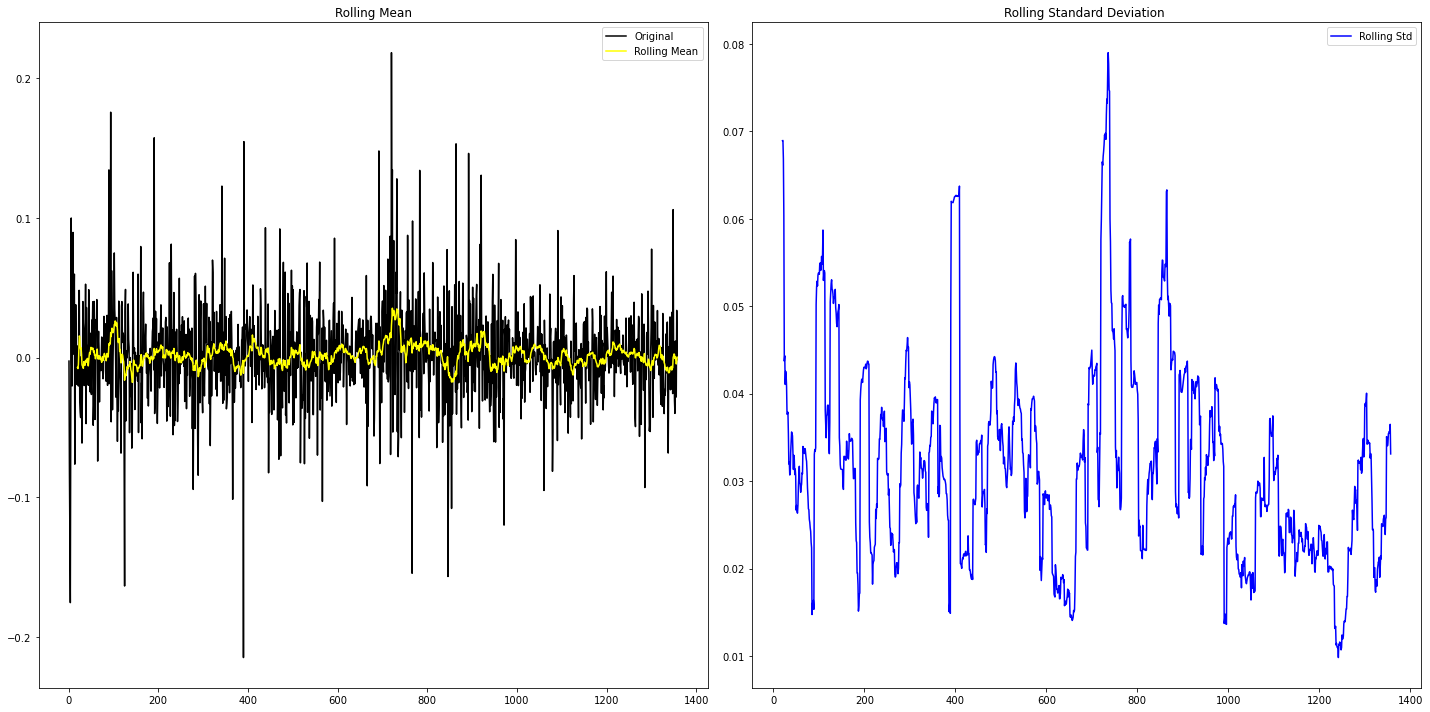

In [31]:
def stationarityTest(timeseries):
    
    #Determining the rolling statistics, using a window of 20 days
    rolling_mean = timeseries.rolling(window=20).mean()
    rolling_std = timeseries.rolling(window=20).std()
    
    #Plotting the rolling statistics
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    axes[0].plot(timeseries, color='black', label='Original')
    axes[0].plot(rolling_mean, color='yellow', label='Rolling Mean')
    axes[0].legend(loc='best')
    axes[0].set_title('Rolling Mean')
    axes[1].plot(rolling_std, color='blue', label='Rolling Std')
    axes[1].legend(loc='best')
    axes[1].set_title('Rolling Standard Deviation ')
    fig.tight_layout()

    
    #Augmented Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

#Computing the differenced log-price process
log_diff = sp_log - sp_log.shift(1)
log_diff.dropna(inplace=True)

#Testing for stationarity
stationarityTest(log_diff)

**Autocorrelation and Partial Autocorrelation**

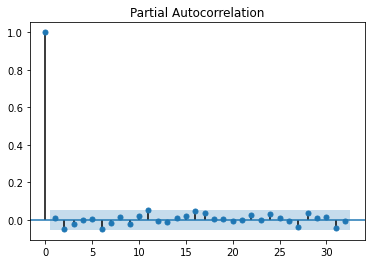

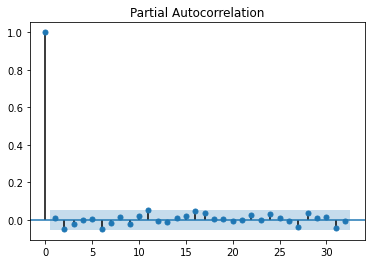

In [32]:
from statsmodels.graphics import tsaplots
tsaplots.plot_pacf(log_diff)

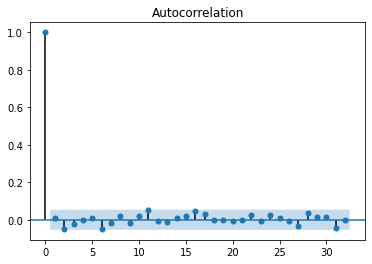

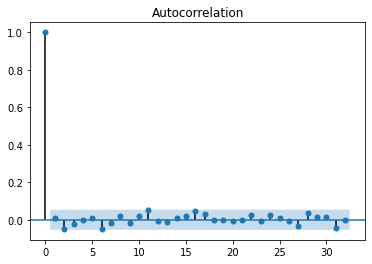

In [33]:
tsaplots.plot_acf(log_diff)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1357
Model:                 ARIMA(5, 1, 1)   Log Likelihood                2642.803
Method:                       css-mle   S.D. of innovations              0.035
Date:                Wed, 03 Feb 2021   AIC                          -5269.606
Time:                        15:18:09   BIC                          -5227.901
Sample:                             1   HQIC                         -5253.991
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.806      0.071      -0.000       0.003
ar.L1.D.y     -0.4746      0.549     -0.865      0.387      -1.550       0.601
ar.L2.D.y     -0.0417      0.031     -1.361      0.1

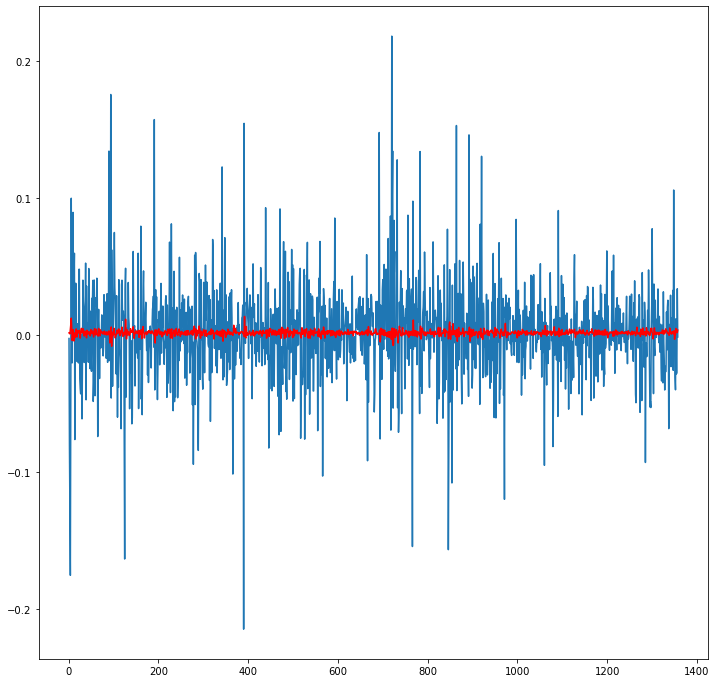

In [34]:
model = ARIMA(np.asarray(log_df), order=(5,1,1))
results = model.fit(disp=-1) 
print(results.summary())
plt.figure(figsize=(12,12))
plt.plot(sp.index[1:],log_diff)
plt.plot(sp.index[1:],results.fittedvalues, color='red')

predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = np.array(predictions_ARIMA_diff.cumsum())
#print(predictions_ARIMA_diff_cumsum)
predictions_ARIMA_diff_cumsum = pd.Series(np.insert(predictions_ARIMA_diff_cumsum,0,0))
predictions_ARIMA = pd.Series(log_df['y'].iloc[0],index=sp.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum)
predictions_ARIMA = np.exp(predictions_ARIMA)


**PREDICTION**


1358


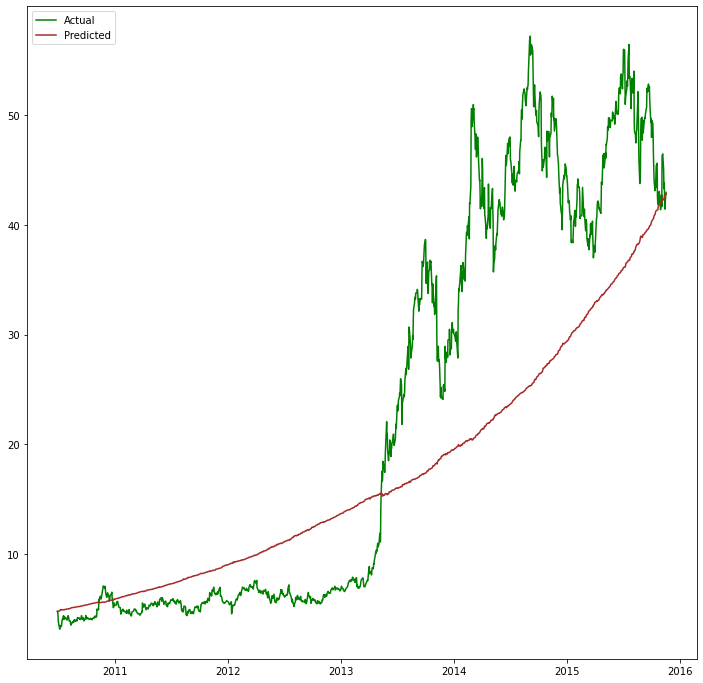

In [35]:
plt.figure(figsize=(12,12))
plt.plot(log_df.index,sp['y'], linestyle='-', color='green',label='Actual')
print(len(log_df.index))
plt.plot(log_df.index,predictions_ARIMA, linestyle='-', color='brown',label='Predicted')

plt.legend()


**Now we will run a simulation with initial money of $1000 on the given stock and calculate our return after 5 years**

In [40]:


def numberOfStocks(currentMoney, stockPrice):
    return currentMoney//stockPrice

initialMoney = 1000 
currentMoney = 1000
firstBuy = True 
shares = 0
sharesInc = 5
wantToBuy = True
dayInc = 7
daysBuy = 1 #number o f days that 1 buy cover


for i in range(dayInc,len(predictions_ARIMA)):
    if(i%daysBuy==0):
        wantToBuy = True
    todayPredictedClose = predictions_ARIMA[i-dayInc]
    tomorrowPredictedClose = predictions_ARIMA[i]
    if tomorrowPredictedClose > todayPredictedClose and wantToBuy:
        stocks = numberOfStocks(currentMoney,sp['y'][i])
        shares += stocks
        currentMoney -= stocks*sp['y'][i]
        wantToBuy = False
    else:
        moneyBack = shares * sp['y'][i]
        currentMoney += moneyBack
        shares = 0

print("After Five years we have $"+str(currentMoney + shares*sp['y'][5*253-1]))

After Five years we have $11934.851232000003
